**This notebook was done as part of the pre-analysis stages**

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

from statsmodels.stats.stattools import durbin_watson


In [2]:
#world bank
world_bank_prices = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/worldbank/CMOHistoricalDataMonthly.MonthlyPrices.csv")
world_bank_prices = world_bank_prices.rename(columns={'MONTH': 'date'})

#teleconnections jra55 #Exogenous ENSO Factors
tc_jra_AO = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.AO.csv")
tc_jra_IOD = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.IOD.csv")
tc_jra_MEI = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.MEI.csv")
tc_jra_NHTELE = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.NHTELE.csv")
tc_jra_PNA = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.PNA.csv")
tc_jra_PSA = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.PSA.csv")
tc_jra_SAM = pd.read_csv("/Users/ritwikgiri/Documents/University of Melbourne/Semester 3/Data Science Project/Project Data and Resources/20230330_student_pack/data/jra55/jra55.SAM.csv")

#prepare data (Commodity wise) - For commodity wise modelling 
world_bank_prices = world_bank_prices[['date','WHEAT_US_HRW','SOYBEANS', 'RICE_05', 'MAIZE']]
world_bank_prices = world_bank_prices.rename(columns={'WHEAT_US_HRW': 'WHEAT'})
world_bank_prices = world_bank_prices.rename(columns={'RICE_05': 'RICE'})
world_bank_prices_WHEAT = world_bank_prices[['date', 'WHEAT']]

In [3]:
# Load and preprocess the datasets
wheat_data = world_bank_prices_WHEAT
mei_data = tc_jra_MEI

# Combine the datasets based on the date column
combined_data = pd.merge(wheat_data, mei_data, on='date')

# Convert date column to datetime format
combined_data['date'] = pd.to_datetime(combined_data['date'])

# Calculate log returns of WHEAT prices
combined_data['Wheat_LR'] = np.log(combined_data['WHEAT']).diff()


#Range are already in comparable state hence we don't require further normalization of data

#Normalize mei between -1 and 1
mei_data = combined_data['mei'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
mei_normalized = scaler.fit_transform(mei_data)
combined_data['mei_normalized'] = mei_normalized

#Normalize WHEAT between -1 and 1 after taking log returns
WHEAT_data = combined_data['WHEAT'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
WHEAT_normalized = scaler.fit_transform(WHEAT_data)
combined_data['WHEAT_normalized'] = WHEAT_normalized


wheat_mei_data = combined_data[['date', 'Wheat_LR', 'mei' ]]
wheat_mei_data_norm = combined_data[['date', 'WHEAT_normalized', 'mei_normalized' ]]
#wheat_mei_data.set_index('date', inplace=True)

In [4]:
wheat_mei_data.head()

,date,Wheat_LR,mei
0,1960-01-01,NaN,-0.307
1,1960-01-02,0.018200,-0.210
2,1960-01-03,0.012060,-0.283
3,1960-01-04,-0.012060,-0.446
4,1960-01-05,-0.055626,-0.477


In [5]:
wheat_mei_data_norm.head()

,date,WHEAT_normalized,mei_normalized
0,1960-01-01,-0.960211,-0.158384
1,1960-01-02,-0.954534,-0.119192
2,1960-01-03,-0.950715,-0.148687
3,1960-01-04,-0.954534,-0.214545
4,1960-01-05,-0.971564,-0.227071


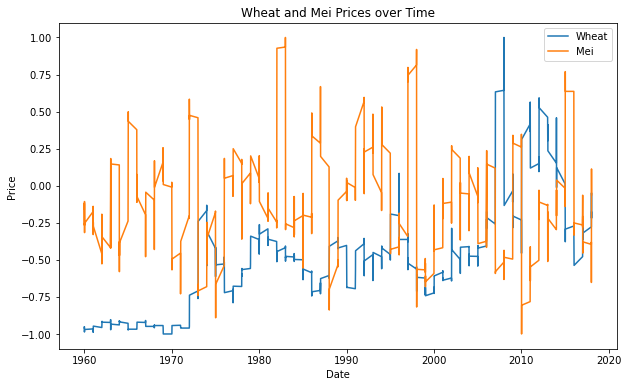

In [6]:
df = wheat_mei_data_norm.copy()
df.set_index('date', inplace=True)


# create the line chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.index, df['WHEAT_normalized'], label='Wheat')
ax.plot(df.index, df['mei_normalized'], label='Mei')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Wheat and Mei Prices over Time')
ax.legend()
plt.show()

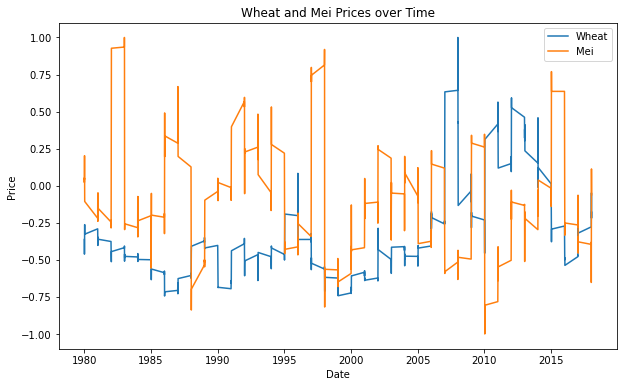

In [7]:
#We see that the mei data from 1980 is more consistent hence we filter our original dataset.

df1 = wheat_mei_data_norm

# Filter the DataFrame to include data from 1980 onwards
df_filtered = df1[df1['date'].dt.year >= 1980]
df_filtered.set_index('date', inplace=True)

# create the line chart
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_filtered.index, df_filtered['WHEAT_normalized'], label='Wheat')
ax.plot(df_filtered.index, df_filtered['mei_normalized'], label='Mei')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Wheat and Mei Prices over Time')
ax.legend()
plt.show()


In [8]:
#Updating the dataset
wheat_mei_data = wheat_mei_data[wheat_mei_data['date'].dt.year >= 1980]
wheat_mei_data_norm = wheat_mei_data_norm[wheat_mei_data_norm['date'].dt.year >= 1980]

In [9]:
wheat_mei_data_norm.head()

,date,WHEAT_normalized,mei_normalized
240,1980-01-01,-0.362904,0.049697
241,1980-01-02,-0.378025,0.022222
242,1980-01-03,-0.425453,0.050909
243,1980-01-04,-0.461475,0.042020
244,1980-01-05,-0.436858,0.072727


In [10]:
wheat_mei_data.head()

,date,Wheat_LR,mei
240,1980-01-01,-0.024800,0.208
241,1980-01-02,-0.016824,0.140
242,1980-01-03,-0.054682,0.211
243,1980-01-04,-0.043626,0.189
244,1980-01-05,0.030018,0.265


In [11]:
columns_of_interest = ['WHEAT_normalized', 'mei_normalized']

# Create a subset DataFrame with the selected columns
df_subset = wheat_mei_data_norm[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_subset.corr()

# Print the correlation matrix
print(correlation_matrix)

                  WHEAT_normalized  mei_normalized
WHEAT_normalized          1.000000       -0.303583
mei_normalized           -0.303583        1.000000


In [12]:
columns_of_interest = ['Wheat_LR', 'mei']

# Create a subset DataFrame with the selected columns
df_subset = wheat_mei_data[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_subset.corr()

# Print the correlation matrix
print(correlation_matrix)

          Wheat_LR       mei
Wheat_LR  1.000000 -0.092313
mei      -0.092313  1.000000


In [13]:
wheat_mei_data.head()

,date,Wheat_LR,mei
240,1980-01-01,-0.024800,0.208
241,1980-01-02,-0.016824,0.140
242,1980-01-03,-0.054682,0.211
243,1980-01-04,-0.043626,0.189
244,1980-01-05,0.030018,0.265


In [14]:
wheat_mei_data = wheat_mei_data_norm.copy()

# Causality Test

Granger causality test is a statistical test used to determine whether one time series can predict or "cause" changes in another time series

The Granger causality test is based on the principle that if variable X Granger-causes variable Y, then the past values of X should provide useful information in predicting the future values of Y, beyond what can be predicted using only the past values of Y itself.

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming you have your dataset loaded into a DataFrame called 'df'

# Select the relevant columns for the test
#data = wheat_mei_data[['Wheat_LR', 'mei']]
data = wheat_mei_data[['WHEAT_normalized', 'mei_normalized']]

# Perform Granger causality tests for different lag values
max_lag = 6  # Maximum number of lags to test
results = grangercausalitytests(data, max_lag, verbose=False)

significant_lags = []

# Iterate over the results for each lag
for lag in range(1, max_lag + 1):
    print(f"Granger causality test (lag={lag}):")
    print(f"Null Hypothesis (H0): 'mei' does not Granger cause 'Wheat_LR'")
    print(f"Alternative Hypothesis (H1): 'mei' Granger causes 'Wheat_LR'")
    print(f"Result (Reject H0): {results[lag][0]['ssr_ftest'][1] < 0.05}")
    
    if results[lag][0]['ssr_ftest'][1] < 0.05:
        significant_lags.append(lag)
    
    print("-" * 50)

print(f"Number of significant lags: {len(significant_lags)}")
print(f"Significant lags: {significant_lags}")

Granger causality test (lag=1):
Null Hypothesis (H0): 'mei' does not Granger cause 'Wheat_LR'
Alternative Hypothesis (H1): 'mei' Granger causes 'Wheat_LR'
Result (Reject H0): True
--------------------------------------------------
Granger causality test (lag=2):
Null Hypothesis (H0): 'mei' does not Granger cause 'Wheat_LR'
Alternative Hypothesis (H1): 'mei' Granger causes 'Wheat_LR'
Result (Reject H0): False
--------------------------------------------------
Granger causality test (lag=3):
Null Hypothesis (H0): 'mei' does not Granger cause 'Wheat_LR'
Alternative Hypothesis (H1): 'mei' Granger causes 'Wheat_LR'
Result (Reject H0): False
--------------------------------------------------
Granger causality test (lag=4):
Null Hypothesis (H0): 'mei' does not Granger cause 'Wheat_LR'
Alternative Hypothesis (H1): 'mei' Granger causes 'Wheat_LR'
Result (Reject H0): True
--------------------------------------------------
Granger causality test (lag=5):
Null Hypothesis (H0): 'mei' does not Grang

Based on the Granger causality test results, there is evidence to suggest that the (t-4) and (t-5) values of 'mei' Granger cause 'Wheat_LR'. However, the (t-1), (t-2), and (t-3) values of 'mei' do not appear to have a Granger causal relationship with 'Wheat_LR'.

We can start with lag = 4 as of now.

# Cointegration Test

The Johansen cointegration test is based on the idea that if two or more variables are cointegrated, there exists a long-term relationship among them that can be represented as a linear combination.

This means that a linear combination of the variables will be stationary, indicating a stable equilibrium relationship.

Cointegration is a statistical property that implies a stable, long-term relationship among the variables. It indicates that the variables move together in the long run, even if they may have short-term fluctuations or divergences.

**Difference with causality:**
Causality is concerned with the direction and strength of influence between variables. It aims to determine whether a change in one variable leads to a change in another variable and if so, the magnitude and significance of this relationship.


In [16]:
# Perform Johansen cointegration test
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Extract test results
trace_stat = result.lr1                      # Trace statistic
trace_crit_vals = result.cvt                 # Critical values for the trace statistic
max_eig_stat = result.lr2                     # Maximum eigenvalue statistic
max_eig_crit_vals = result.cvm                # Critical values for the maximum eigenvalue statistic

total_ranks = max(len(trace_stat), len(max_eig_stat))

print("Johansen Cointegration Test Results:")
print("------------------------------------")
print("Trace Statistic:")
for i in range(total_ranks):
    rank = i + 1
    if i < len(trace_stat):
        null_hypothesis = f"H0: There is no cointegration (Rank <= {rank - 1})"
        presence_coint = "Cointegration is present" if trace_stat[i] > trace_crit_vals[i, 2] else "Cointegration is not present"
        print(f"{null_hypothesis}\nResult: {presence_coint}\n")

print("Maximum Eigenvalue Statistic:")
for i in range(total_ranks):
    rank = i + 1
    if i < len(max_eig_stat):
        null_hypothesis = f"H0: There is no cointegration (Rank <= {rank - 1})"
        presence_coint = "Cointegration is present" if max_eig_stat[i] > max_eig_crit_vals[i, 2] else "Cointegration is not present"
        print(f"{null_hypothesis}\nResult: {presence_coint}\n")

Johansen Cointegration Test Results:
------------------------------------
Trace Statistic:
H0: There is no cointegration (Rank <= 0)
Result: Cointegration is present

H0: There is no cointegration (Rank <= 1)
Result: Cointegration is present

Maximum Eigenvalue Statistic:
H0: There is no cointegration (Rank <= 0)
Result: Cointegration is present

H0: There is no cointegration (Rank <= 1)
Result: Cointegration is present



 total rank indicates the maximum number of cointegrating relationships present in the system.
 Here, the rank is 1, that means that there is a presence of 1 cointegrating relationships among the variables. (mei and Wheat_LR)

The results suggest that there is evidence of cointegration between the 'Wheat_LR' and 'mei' variables. Both the trace statistic and maximum eigenvalue statistic indicate the presence of at least one cointegrating relationship. Additionally, the results specifically support the existence of two cointegrating relationships between the variables.

In [17]:
# Perform Johansen cointegration test
result = coint_johansen(data, det_order=0, k_ar_diff=1)

# Extract test results
eigenvectors = result.evec                       # Eigenvectors associated with cointegrating relationships
ranks = total_ranks                              # Total ranks or maximum number of cointegrating relationships

# Determine lags based on eigenvectors
lags = result.eig                                # Lag order determined by the maximum lag in the cointegration equations

# Print cointegration equations and lags
for rank in range(ranks):
    print(f"Cointegration Equations for Rank {rank+1}:")
    for i in range(len(data.columns)):
        equation = f"{data.columns[i]} = "
        for j in range(rank+1):
            coefficient = eigenvectors[i, j]
            lag_term = f"lag({data.columns[j]}, {j+1})" if j > 0 else ""
            equation += f"{coefficient:.4f} * {lag_term} + "
        equation += "constant"
        print(equation)
    print(f"Lags for Rank {rank+1}: {lags[rank]}")
    print()


Cointegration Equations for Rank 1:
WHEAT_normalized = 1.1744 *  + constant
mei_normalized = 2.7799 *  + constant
Lags for Rank 1: 0.07668741737933366

Cointegration Equations for Rank 2:
WHEAT_normalized = 1.1744 *  + 2.9841 * lag(mei_normalized, 2) + constant
mei_normalized = 2.7799 *  + -0.1650 * lag(mei_normalized, 2) + constant
Lags for Rank 2: 0.016287836039245496



**Interpretation**
The equation suggests that in the long run, the 'Wheat_LR' variable is influenced by a coefficient of 22.3983 times the current value of the 'Wheat_LR' variable itself, and there is no lag term involved in this relationship. Similarly, the 'mei' variable is influenced by a coefficient of 0.1571 times the current value of the 'mei' variable itself, and there is no lag term involved.

cointegration equation shows how the variables are related to each other in the long run. 

# Test and Make Stationary

In [18]:
wheat_mei_data = wheat_mei_data.set_index('date')
wheat_mei_data.head()

,WHEAT_normalized,mei_normalized
date,,
1980-01-01,-0.362904,0.049697
1980-01-02,-0.378025,0.022222
1980-01-03,-0.425453,0.050909
1980-01-04,-0.461475,0.042020
1980-01-05,-0.436858,0.072727


WHEAT_normalized True
mei_normalized True
1
number of times differencing 1


[]

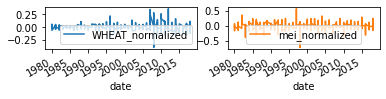

In [19]:
# ADF Test

# check if p-value is < 0.05 for all variables

def adftest(df):
  is_stationary = True
  for col in df.columns.values:
    test_result = adfuller(df[col], autolag="AIC")
    if test_result[1] > 0.05:
      is_stationary = False
    print(col, test_result[1] < 0.05)

  return is_stationary

# Make Stationary by repeated differencing
is_stationary = False
df_diff = wheat_mei_data.copy()
count_diff = 0

while not is_stationary:
  df_diff = df_diff.diff().dropna()
  is_stationary = adftest(df_diff)
  count_diff += 1
  print(count_diff)
  
print("number of times differencing", count_diff)
df_diff.plot(subplots=True, layout=(4, 2))
plt.plot()

From the output above we see that both the variables are stationary. Hence, we will use the wheat_mei_data.

# Train Model with Vector Auto Regression (VAR)

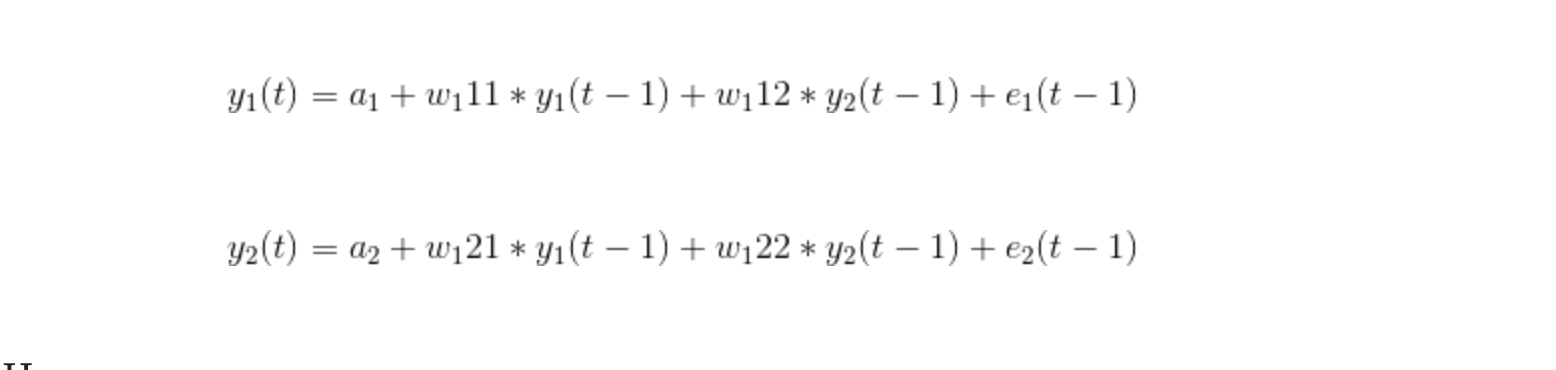

https://medium.com/analytics-vidhya/a-multivariate-time-series-guide-to-forecasting-and-modeling-with-python-codes-8733b5fd1a56

In [20]:
train_size = int(0.9 * len(wheat_mei_data))
df_train, df_test = wheat_mei_data[:train_size], wheat_mei_data[train_size:]

# n = 4
# df_train, df_test = wheat_mei_data[:-n], wheat_mei_data[-n:]

# Select Order(p) of VAR
model = VAR(df_train)
model.select_order(maxlags=12).summary()

/Users/ritwikgiri/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-4.103,-4.084,0.01652,-4.096
1,-9.570,-9.511,6.979e-05,-9.547
2,-9.837,-9.739*,5.345e-05,-9.798
3,-9.846,-9.708,5.297e-05,-9.791
4,-9.911,-9.735,4.961e-05,-9.841*
5,-9.905,-9.689,4.993e-05,-9.819
6,-9.921*,-9.666,4.912e-05*,-9.820
7,-9.909,-9.614,4.974e-05,-9.792
8,-9.919,-9.586,4.922e-05,-9.787
9,-9.909,-9.536,4.974e-05,-9.761


AIC (Akaike Information Criterion): Measures the trade-off between model fit and complexity; the lag with the lowest AIC is chosen as the optimal lag.

BIC (Bayesian Information Criterion): Similar to AIC, but penalizes more for model complexity; the lag with the lowest BIC is selected.

FPE (Final Prediction Error): Estimates the fit of the model; the lag with the lowest FPE is considered.

HQIC (Hannan-Quinn Information Criterion): Balances model fit and complexity; the lag with the lowest HQIC is preferred.

Based on this the lag value of 6 is consistently the best choice. The lower AIC, BIC, FPE, and HQIC values indicate a better fit of the model. 

But we can consider lag 4 as well as it has lowest BIC and HQIC value.

In [21]:
# Fit the Model
model_fitted_2 = model.fit(2) #lag 2
model_fitted_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jul, 2023
Time:                     11:19:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.77019
Nobs:                     419.000    HQIC:                  -9.82847
Log likelihood:           887.974    FPE:                5.18809e-05
AIC:                     -9.86656    Det(Omega_mle):     5.06645e-05
--------------------------------------------------------------------
Results for equation WHEAT_normalized
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.011146         0.004914           -2.268           0.023
L1.WHEAT_normalized         1.220841         0.047760           25.562           0.000
L1.mei_normalized        

In [22]:
model_fitted_6 = model.fit(6) #lag 6
model_fitted_6.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jul, 2023
Time:                     11:19:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.67623
Nobs:                     415.000    HQIC:                  -9.82881
Log likelihood:           908.467    FPE:                4.87616e-05
AIC:                     -9.92861    Det(Omega_mle):     4.58445e-05
--------------------------------------------------------------------
Results for equation WHEAT_normalized
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.010063         0.005121           -1.965           0.049
L1.WHEAT_normalized         1.253846         0.049626           25.266           0.000
L1.mei_normalized        

# Residual Serial Correlation Test

check if the residual of the model still contains leftover pattern. If yes, then we will need to make changes to the model e.g. increase the order of the VAR model.

Durbin Watson’s statistic to check if there are serial correlations between residuals. If the test statistic is close to 2 means there’s no correlation. Meanwhile, close to 0 means positive and to 4 means negative correlation respectively.

In [23]:
# Serial Correlation Test on Residual with Durbin Watson

test_result = durbin_watson(model_fitted_2.resid)
list(zip(df.columns, test_result))
# results are close to two so no serial correlation left

[('WHEAT_normalized', 1.945071262492814),
 ('mei_normalized', 1.8849211936490766)]

In [24]:
# Serial Correlation Test on Residual with Durbin Watson

test_result = durbin_watson(model_fitted_6.resid)
list(zip(df.columns, test_result))
# results are close to two so no serial correlation left

[('WHEAT_normalized', 1.997012572957888),
 ('mei_normalized', 2.0003372490034383)]

Close to 0 hence no correlation.

# Forecast and Evaluate

In [25]:
# Number of steps to forecast
n_forecast_steps = len(df_test)

# Forecasting
forecast_values = model_fitted_2.forecast(model_fitted_2.endog, steps=n_forecast_steps)

# Extract the actual values from the test dataset
actual_values = df_test.values
dates = df_test.index
# Calculate evaluation metrics
mae = np.mean(np.abs(forecast_values - actual_values), axis=0)
mse = np.mean((forecast_values - actual_values)**2, axis=0)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): [0.1577925  0.30531696]
Mean Squared Error (MSE): [0.03397148 0.15773762]
Root Mean Squared Error (RMSE): [0.18431353 0.39716195]


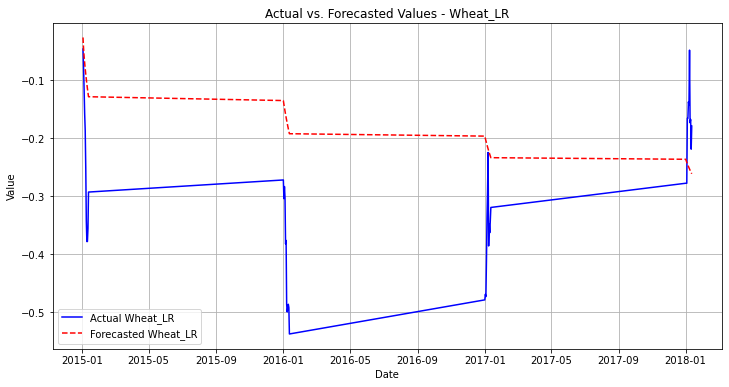

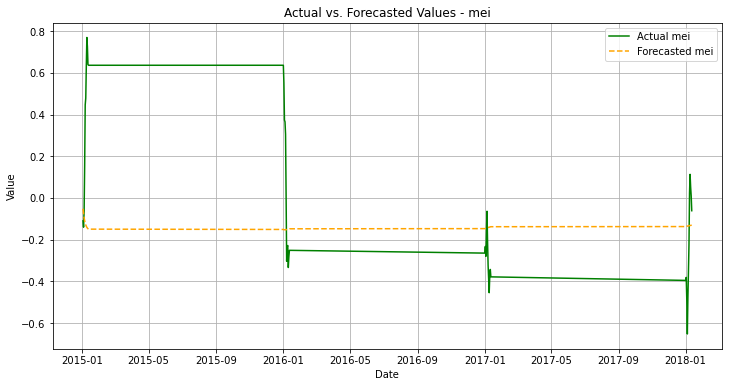

In [26]:
# Plotting Actual and Forecasted Values for 'Wheat_LR'
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values[:, 0], label='Actual Wheat_LR', color='blue')
plt.plot(dates, forecast_values[:, 0], label='Forecasted Wheat_LR', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values - Wheat_LR')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Actual and Forecasted Values for 'mei'
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values[:, 1], label='Actual mei', color='green')
plt.plot(dates, forecast_values[:, 1], label='Forecasted mei', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecasted Values - mei')
plt.legend()
plt.grid(True)
plt.show()

'Wheat' as the response variable and 'mei' as the explanatory variable, it is more appropriate to use VARIMA or VARMAX models, which are designed explicitly for multivariate time series analysis.